## This is a user friendly Jupyter notebook program that allows the user to choose an image, display it as well as its histogram(s) and apply to it any one of the following point transformations: linear stretching, histogram equalization, and power transformation.

In [1]:
### Tkinter stuff
from tkinter import *
from PIL import ImageTk, Image
from tkinter import filedialog
from tkinter import ttk

### Image processing stuff
import numpy as np
from skimage import io, exposure
from skimage.color import rgb2hsv, hsv2rgb

### Plotting stuff
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

# Helping Functions

In [2]:
## Helper functions
def prepare_canvas(*args, **fig_kw):
    fig, axes = plt.subplots(*args, **fig_kw)
    canvas = FigureCanvas(fig)
    return fig, canvas, axes

def plottoarray(fig, canvas):
    '''
    Convert the given figure to a numpy array
    '''
    canvas.draw()                 # draw the canvas, cache the renderer
    width, height = map(int, fig.get_size_inches() * fig.get_dpi())
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)
    return image

def his(img):
    '''
    Plot the histograms of the image
    '''
    hist0=exposure.histogram(img)
    mini=np.min(img)
    maxi=np.max(img)
    grays=np.linspace(mini,maxi,len(hist0[0]))
    return grays, hist0[0]

def iscolored(image):
    '''
    Check if the image is grayscale or colored
    '''
    if len(image.shape) == 3:
        return True
    else:
        return False
def image_to_histogramplots(image):

    ## if the loaded image is grayscale
    if not iscolored(image):
        ## prepare canvas
        fig, canvas, axes = prepare_canvas(1,2,figsize=(8,4))
        fig.tight_layout(pad=3.0)
        ## generate the histogram plot (grayscale)
        axes[0].imshow(image, cmap='gray')
        axes[0].axis('off')
        ## chck if the image in 0-1 range, if not,map it to 0-255 range
        is_less_eq_one = image <= 1
        if np.all(is_less_eq_one):
            image = 255 * image
        axes[1].plot(his(image)[0],his(image)[1], color = 'black' )
        axes[1].set_title('histogram');
        axes[1].set_xticks(range(0,260,25))

    
    else: # if the loaded image is colored
        fig, canvas, axes = prepare_canvas(1,4,figsize=(16,4))
        fig.tight_layout(pad=3.0)
        
        ## generate the histogram plots (RGB)
        axes[0].imshow(image)
        axes[0].axis('off')
        image = 255 * image
        axes[1].plot(his(image[:,:,0])[0],his(image[:,:,0])[1], color = 'red' )
        axes[1].set_title('Red channel histogram');
        axes[1].set_xticks(range(0,260,25))

        axes[2].plot(his(image[:,:,1])[0],his(image[:,:,1])[1], color = 'green' )
        axes[2].set_title('Green channel histogram');
        axes[2].set_xticks(range(0,260,25))

        axes[3].plot(his(image[:,:,2])[0],his(image[:,:,2])[1], color = 'blue' )
        axes[3].set_title('Blue channel histogram');
        axes[3].set_xticks(range(0,260,25))
    
    ## convert the plot to numpy array (as an image)
    plots = plottoarray(fig, canvas)

    # convert the plots to PIL format
    pil_plots = Image.fromarray(plots)


    # ...and then to ImageTk format
    tk_plots = ImageTk.PhotoImage(pil_plots)
    return tk_plots, pil_plots

def save_plot(img):
    '''
    Save the image by displaying save file window
    @params
    img: an image in PIL fromat
    '''
    filename = filedialog.asksaveasfile(mode='w',defaultextension='.jpg')
    print(filename)
    if not filename:
        return
    img.save(filename.name)
        
      
def linear_stretching(lower_p, upper_p):
    global image, panelB
    lower_pval = int(lower_p.get())
    upper_pval = int(upper_p.get())
    
    if not iscolored(image): #if grayscale image
        ## get the percentiles from the function params 
        p1 = np.percentile(image, lower_pval)
        p2 = np.percentile(image, upper_pval)
        ## check if the percentiles are in the required range
#         assert p1 >= 0 and p2 <= 100 and p1 < p2, "Enter percentile values satisying the following conditions: p1 >= 0 and p2 <= 100 and p1 < p2"
        # perform the linear transformation on the image
        res = exposure.rescale_intensity(image, in_range=(p1, p2)) ### enter the precentile values to be ignored from the original image
        ## get the image version of the histograms of the image
        plots, pil_plots = image_to_histogramplots(res.astype('float32'))
            
    else: #if colored image
        ## convert to HSV space
        hsv_img = rgb2hsv(image)
        hue_channel = hsv_img[:, :, 0]
        saturation_channel = hsv_img[:, :, 1]
        value_channel = hsv_img[:, :, 2]
        ## get the percentiles from the function params 
        p1 = np.percentile(value_channel, lower_pval)
        p2 = np.percentile(value_channel, upper_pval)
        # perform the linear transformation on the value channel
        res_vchannel = exposure.rescale_intensity(value_channel, in_range=(p1, p2)) ### enter the precentile values to be ignored from the original image
        ## stack the channels
        res = np.dstack((hue_channel, saturation_channel, res_vchannel))
        ## back to RGB version
        rgb_img = hsv2rgb(res)
        ## get the image version of the histograms of the image
        plots, pil_plots = image_to_histogramplots((rgb_img).astype('float32'))
        
      
    ## put the images in the GUI
    if panelB is None:
        panelB = Label(image=plots)
        panelB.image = plots
        panelB.grid(row=6, column=0, columnspan = 2)
            
    else:
        panelB.configure(image=plots)
        panelB.image = plots 
        
    ## Save button
    save_btn.config(command= lambda: save_plot(pil_plots))
    save_btn.grid(row=7, column=0, columnspan=2)
        

def histogram_equalization():
    global image, panelB
    if not iscolored(image): #if grayscale image
        # perform the histogram equalization on the value channel
        res = exposure.equalize_hist(image)
        plots, pil_plots = image_to_histogramplots(res.astype('float32'))
        
            
    else: #if colored image
        ## convert to HSV space
        hsv_img = rgb2hsv(image)
        hue_channel = hsv_img[:, :, 0]
        saturation_channel = hsv_img[:, :, 1]
        value_channel = hsv_img[:, :, 2]
        # perform the histogram equalization on the value channel
        res_vchannel = exposure.equalize_hist(value_channel)
        # stack the channels
        res = np.dstack((hue_channel, saturation_channel, res_vchannel))
        ## back to RGB version
        rgb_img = hsv2rgb(res)
        ## get the image version of the histograms of the image
        plots, pil_plots = image_to_histogramplots((rgb_img).astype('float32'))
        
    ## display in GUI
    if panelB is None:
        panelB = Label(image=plots)
        panelB.image = plots
        panelB.grid(row=6, column=0, columnspan = 2)
            
    else:
        panelB.configure(image=plots)
        panelB.image = plots 
    
    ## Save button
    save_btn.config(command= lambda: save_plot(pil_plots))
    save_btn.grid(row=7, column=0, columnspan=2)
    
        
def power_transformation(constant_multi, gamma):
    global image, panelB
    ## convert the input values to floats
    constant_multi_val = float(constant_multi.get())
    gamma_val = float(gamma.get())
    
    if not iscolored(image):    #if grayscale image
        # perform power transformation on the value channel
        res = exposure.adjust_gamma(image, gamma_val, constant_multi_val)
        ## get the image version of the histograms of the image
        plots, pil_plots = image_to_histogramplots(res.astype('float32'))
            
    else: #if colored image
        ## convert to HSV space
        hsv_img = rgb2hsv(image)
        hue_channel = hsv_img[:, :, 0]
        saturation_channel = hsv_img[:, :, 1]
        value_channel = hsv_img[:, :, 2]
        
        # perform power transformation on the value channel
        res_vchannel = exposure.adjust_gamma(value_channel, gamma_val, constant_multi_val)
        # stack the channels
        res = np.dstack((hue_channel, saturation_channel, res_vchannel))
        ## back to RGB version
        rgb_img = hsv2rgb(res)
        ## get the image version of the histograms of the image
        plots, pil_plots = image_to_histogramplots((rgb_img).astype('float32'))
        
    ## display in GUI
    if panelB is None:
        panelB = Label(image=plots)
        panelB.image = plots
        panelB.grid(row=6, column=0, columnspan = 2)
            
    else:
        panelB.configure(image=plots)
        panelB.image = plots 
        
    ## Save button
    save_btn.config(command= lambda: save_plot(pil_plots))
    save_btn.grid(row=7, column=0, columnspan=2)
        
    
    
def select_point_callbackFunc(event):
    '''
    For the combobox options, get the value and perform the required transformation
    '''
    if event.widget.get() == 'Linear Stretching':
        ## hide the other widgets
        constant_multi_label.grid_forget()
        gamma_label.grid_forget()
        constant_multi.grid_forget()
        gamma.grid_forget()
        
        ## place this option's widgets
        lower_p_label.grid(row=3, column = 0)
        upper_p_label.grid(row=4, column = 0)
        lower_p.grid(row=3, column = 1)
        upper_p.grid(row=4, column = 1)
        check_btn.grid_forget()
        
        ## perform the required transformation
        check_btn.config(command=lambda: linear_stretching(lower_p, upper_p))
        check_btn.grid(row=5, column=0, columnspan = 2)
        
    elif event.widget.get() == 'Histogram Equalization':
        ## hide the other widgets
        lower_p_label.grid_forget()
        upper_p_label.grid_forget()
        lower_p.grid_forget()
        upper_p.grid_forget()
        check_btn.grid_forget()
        
        constant_multi_label.grid_forget()
        gamma_label.grid_forget()
        constant_multi.grid_forget()
        gamma.grid_forget()
        check_btn.grid_forget()
        
        ## perform the required transformation
        check_btn.config(command=histogram_equalization)
        check_btn.grid(row=5, column=0, columnspan = 2)
        
    else: ## Power law transformation
        
        ## hide the other widgets
        lower_p_label.grid_forget()
        upper_p_label.grid_forget()
        lower_p.grid_forget()
        upper_p.grid_forget()
        check_btn.grid_forget()
        
        ## place this option's widgets
        constant_multi_label.grid(row=3, column = 0)
        gamma_label.grid(row=4, column = 0)
        constant_multi.grid(row=3, column = 1)
        gamma.grid(row=4, column = 1)
        check_btn.grid_forget()
        
        ## perform the required transformation
        check_btn.config(command=lambda: power_transformation(constant_multi, gamma))
        check_btn.grid(row=5, column=0, columnspan = 2)
    
  
def select_image():
    global panelA, dropdown, combolabel, image
    ## ask for the image to be opened
    path = filedialog.askopenfilename()
    
    if len(path) > 0: # check if there is an image already
        ## read the image
        image = io.imread(path)
        
        ## get the image version of the histograms of the image
        plots, pil_plots = image_to_histogramplots(image)
        
        ## display in GUI
        if panelA is None:
            panelA = Label(image=plots)
            panelA.image = plots
            panelA.grid(row=1, column=0, columnspan = 2)
            
        else:
            panelA.configure(image=plots)
            panelA.image = plots
            
        ## place the combobox
        point_combolabel.grid(row = 2, column = 0) 
        point_combo.grid(row = 2, column = 1) 

# GUI

None


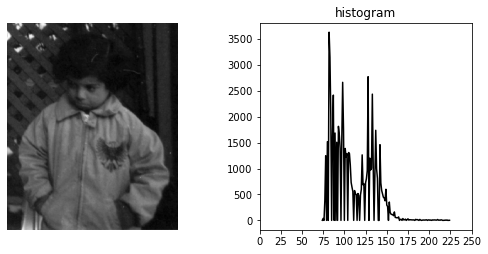

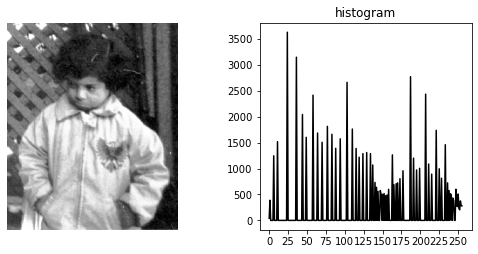

In [3]:
## initialize the root
root = Tk()
## set a white background
root.configure(bg='white')
panelA = None
panelB = None

## 'Select image' button
btn = Button(root, text = "Select an image", command = select_image)
btn.grid(row=0, column=0, padx=10, pady = 10, columnspan = 2)


### Combo for choosing point transformation
point_combolabel = Label(root, text = "Choose a point transformation:",  
          background = 'white', foreground ="black",  
          font = ("Times New Roman", 15))

point_combo = ttk.Combobox(root, state = 'readonly')
point_combo['values'] = ('Linear Stretching', 'Histogram Equalization', 'Power Tranformation')

point_combo.bind("<<ComboboxSelected>>", select_point_callbackFunc)

#### linear stretching elements
lower_p_label = Label(root,text="Set lower percentile:", background = 'white')
upper_p_label = Label(root,text="Set upper percentile:", background = 'white')
lower_p = Entry(root)
upper_p = Entry(root)

check_btn = Button(root, text="Show Result")

### No Histogram Equalization elements

#### Power transformation elements
constant_multi_label = Label(root,text="Set the constant multiplier:", background = 'white')
gamma_label = Label(root,text="Set gamma:", background = 'white')
constant_multi = Entry(root)
gamma = Entry(root)



### Save button
save_btn = Button(root, text='Save result')

root.mainloop()

# **Explanation and Justification**

<h1 style="text-align: center;">Picture 1</h1>
<h3 style="text-align: center;">Before: </h3>
<img src="problem 1.jpg"  style="display: block;margin-left: auto;margin-right: auto;width:25%;" />
<h3 style="text-align: center;">After: </h3>
<img src="problem 1 equal.jpg" style="display: block;margin-left: auto;margin-right: auto;" />


#### Histogram Equalization works well on this image since the original image has a low contrast. This technique enhances the contrast of the images by making the histogram of the luminance of the output image approximately matches the uniform distribution. As seen from the original histograms of the image, the color values are concentrated around a small range. After equalization, the values are spread over the whole range with approximately a uniform distribution. This shows a better division of intensities and a better contrast.



<h1 style="text-align: center;">Picture 2</h1>
    <h3 style="text-align: center;">Before: </h3>
<img src="problem 2.gif" style="display: block;margin-left: auto;margin-right: auto;width:25%;" />
<h3 style="text-align: center;">After: </h3>
<img src="problem 2 power.gif" style="display: block;margin-left: auto;margin-right: auto;" />

#### Here, we need to see the dark parts of the image. The plate is very dark making it difficult to read the written number. Power transformation does the required job with $\gamma \lt 1 \text{ (used } \gamma = 0.2 \text{)}$ and $c=1$, allowing us to see the hidden number written on the plate. The main job is to increase the dynamic range of the dark areas and reduce the dynamic range of bright areas.



<h1 style="text-align: center;">Picture 3</h1>
    <h3 style="text-align: center;">Before: </h3>
<img src="problem 3.jpg" style="display: block;margin-left: auto;margin-right: auto;width:25%;" />
<h3 style="text-align: center;">After: </h3>
<img src="problem 3 linear.jpg" style="display: block;margin-left: auto;margin-right: auto;" />

#### As it is apparent from the histogram of the original image, most of the pixel values are located in the dark range i.e. 0-75. This results in a very dark image. Linear transformation performs linear stertching for these values to cover the whole range 0 - 255. Producing the above image requires setting the lower percentile to 5 and the upper percentile to 92. This means that the first 5% and upper 8% of pixel values are ignored. This is useful to reduce the impact of outliers in the image.